# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
from scipy.ndimage import gaussian_filter1d
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.proc_beh import get_all_transition, get_transitions_state, build_poke_df
from mecll.proc_neural import get_all_resps, get_mean_resps, align_activity
from mecll.load import load_data


In [3]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [32]:
root_path = '/Users/yves/Downloads/example_files4/'
out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

In [33]:
spkT_ms = aligner.A_to_B(spkT)

In [34]:
df = build_poke_df(lines,events)


In [35]:
#poke_dict_t1 ={}
#poke_dict_t2 = {}

dicts = [{} for _ in range(4)]

for port_nr in np.unique(df['state'].values):
    
    kk = 0
    for task_nr in range(2):
        for direction in np.unique(df['direction'].values):
            task_nr = str(task_nr)
            indices = np.where((df['state']==port_nr) &
                               (df['correct']==True) & 
                               (df['direction']==direction) &
                               (df['port_repeat']==False) & 
                               (df['task_nr']==task_nr))[0]
            indices = indices[indices>0]
            v = df.loc[indices]['time'].values
            prev_v = df.loc[indices-1]['time'].values
            #print(direction,df.loc[indices]['state'].values - df.loc[indices-1]['state'].values)

            
            dicts[kk][str(port_nr)] = [[float(j),float(i)] for i,j in zip(v,prev_v) if (i-j)<800]
            dicts[kk]['task_nr'] = str(task_nr)
            dicts[kk]['direction'] = str(direction)
            dicts[kk]['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            dicts[kk]['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            kk += 1


In [36]:
np.unique(df['graph_type'])

array(['loop'], dtype=object)

In [10]:
n_timepoints = 25
n_neurons = len((list(set(spk_join[0]))))

all_big_array = []
split_half_big_array = []
all_mean_durations = []
for dict_ix in [2,3]:
    
    big_array = np.zeros([n_neurons,n_timepoints*9])
    mean_durations = []
    for state_nr in range(9):

        direction = dicts[dict_ix]['direction']
        trial_events = np.array(dicts[dict_ix][str(state_nr)])
        
        try:
            mean_duration = np.mean(np.diff(trial_events,axis=1))
        except:# AxisError:
            mean_duration = np.nan
        mean_durations.append(mean_duration)

        if len(trial_events)>0:
            
            out = align_activity(trial_events,np.array([0,1000]),spk_join,fs=25)
            aligned_rates, t_out, min_max_stretch = out

            mean_aligned_rates = np.nanmean(aligned_rates,axis=0)
        else:
            mean_aligned_rates = np.zeros([n_neurons,n_timepoints]) + np.nan
        if direction=='-1':
            big_array[:,state_nr*n_timepoints:(state_nr+1)*n_timepoints] = np.fliplr(mean_aligned_rates)
        if direction=='1':
            big_array[:,(1+state_nr-1)*n_timepoints:(1+state_nr)*n_timepoints] = mean_aligned_rates

    all_big_array.append(big_array)
    all_mean_durations.append(mean_durations)

In [14]:
all_big_array[0].shape

(313, 225)

In [168]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=poke_dict_t1['seq'])

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=poke_dict_t2['seq'])
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=poke_dict_t2['seq'])

In [13]:
plt.figure(figsize=(12,5))
plt.imshow(store_g1_p1-np.mean(store_g1_p1,axis=1)[:,None],cmap='RdBu_r',interpolation='None',aspect=3)
for ii in range(9):
    plt.axvline(x=ii*80,linestyle='--',color='.3',alpha=.1)
plt.ylim(100,0)
plt.colorbar()

NameError: name 'store_g1_p1' is not defined

<Figure size 864x360 with 0 Axes>

In [ ]:
evals_shuff = []
for ctr in range(100):
    sys.stdout.write('\riter_num:{}'.format(ctr))
    sys.stdout.flush()
    store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
    store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=np.random.permutation(poke_dict_t1['seq']))

    store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=np.random.permutation(poke_dict_t2['seq']))
    store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=np.random.permutation(poke_dict_t2['seq']))
    

    conditions =  np.logical_and.reduce([ccs_across<.3,
                                        ccs_within>=.3])
    store_g1_filt = store_g1_p1[conditions]
    store_g1_cv_filt = store_g1_p2[conditions]
    store_g2_filt = store_g2_p1[conditions]
    store_g2_cv_filt = store_g2_p2[conditions]
    
    
    U,D,V = np.linalg.svd(store_g1_filt)
    #U2,D2,V2 = np.linalg.svd(store_g2_filt)
    evals = U.T.dot(store_g2_filt).dot(V.T).diagonal()
    evals_shuff.append(evals)


In [37]:
store_g1_p1 = get_mean_activity_matrix(all_resps_g1_single_trial,half=1,order=poke_dict_t1['seq'])
store_g1_p2 = get_mean_activity_matrix(all_resps_g1_single_trial,half=2,order=poke_dict_t1['seq'])

store_g2_p1 = get_mean_activity_matrix(all_resps_g2_single_trial,half=1,order=poke_dict_t2['seq'])
store_g2_p2 = get_mean_activity_matrix(all_resps_g2_single_trial,half=2,order=poke_dict_t2['seq'])

NameError: name 'get_mean_activity_matrix' is not defined

In [57]:

conditions =  np.logical_and.reduce([ccs_across<99,
                                    ccs_within>=.3])
store_g1_filt = store_g1_p1[conditions]
store_g1_filt = store_g1_filt - np.mean(store_g1_filt,axis=1)[:,None]
#store_g1_filt = store_g1_filt/np.std(store_g1_filt,axis=1)[:,None]

store_g1_cv_filt = store_g1_p2[conditions]
store_g1_cv_filt = store_g1_cv_filt - np.mean(store_g1_cv_filt,axis=1)[:,None]

store_g2_filt = store_g2_p1[conditions]
store_g2_filt = store_g2_filt - np.mean(store_g2_filt,axis=1)[:,None]
#store_g2_filt = store_g1_filt/np.var(store_g2_filt,axis=1)[:,None]

store_g2_cv_filt = store_g2_p2[conditions]
store_g2_cv_filt = store_g2_cv_filt - np.mean(store_g2_cv_filt,axis=1)[:,None]


In [11]:
from mecll.SVD_analysis import variance_explained_U, variance_explained_V, variance_explained_both

In [151]:
ev_cv1_U, ev_alt1_U = variance_explained_U(store_g1_filt,store_g1_cv_filt,store_g2_filt)
ev_cv1_V, ev_alt1_V = variance_explained_V(store_g1_filt,store_g1_cv_filt,store_g2_filt)
ev_cv1_B, ev_alt1_B = variance_explained_both(store_g1_filt,store_g1_cv_filt,store_g2_filt)


ev_cv2_U, ev_alt2_U = variance_explained_U(store_g2_filt,store_g2_cv_filt,store_g1_filt)
ev_cv2_U, ev_alt2_U = variance_explained_V(store_g2_filt,store_g2_cv_filt,store_g1_filt)
ev_cv2_B, ev_alt2_B = variance_explained_both(store_g2_filt,store_g2_cv_filt,store_g1_filt)

In [129]:
Sbig = np.eye(U.shape[0],V.shape[0])
Sbig[np.arange(U.shape[0]),np.arange(U.shape[0])] = S

In [134]:
np.allclose(U.dot(Sbig).dot(V),store_g1_filt)

True

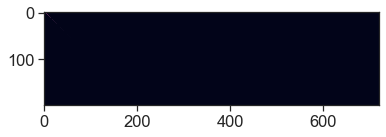

In [124]:
plt.imshow(tmp_,interpolation='None')

In [60]:
#calculate explained variance explained by U
evals_alt = np.sum(U.T.dot(store_g2_filt)**2,axis=1)
norm_evals_alt = evals_alt/np.sum(evals_alt)

In [61]:
#calculate explained variance explained by U
evals_cv = np.sum(U.T.dot(store_g1_cv_filt)**2,axis=1)
norm_evals_cv = evals_cv/np.sum(evals_cv)

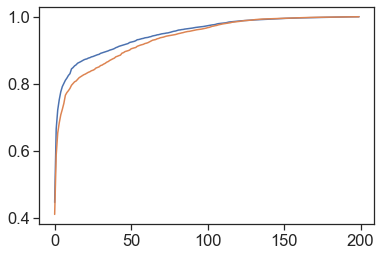

In [62]:
plt.plot(np.cumsum(norm_evals_cv))
plt.plot(np.cumsum(norm_evals_alt))

In [145]:
def variance_explained_U(store_ref,store_cv,store_alt):
    U,S,V = np.linalg.svd(store_ref)
    
    #calculate explained variance explained by U
    ev_cv = np.sum(U.T.dot(store_cv)**2,axis=1)
    norm_ev_cv = ev_cv/np.sum(ev_cv)

    #calculate explained variance explained by U
    ev_alt = np.sum(U.T.dot(store_alt)**2,axis=1)
    norm_ev_alt = ev_alt/np.sum(ev_alt)
        
    return norm_ev_cv, norm_ev_alt

In [150]:
def variance_explained_both(store_ref,store_cv,store_alt):

    U,S,V = np.linalg.svd(store_ref)

    
    ev_cv = U.T.dot(store_cv).dot(V.T).diagonal()**2
    norm_ev_cv = ev_cv/np.sum(ev_cv)
    
    
    ev_alt = U.T.dot(store_alt).dot(V.T).diagonal()**2
    norm_ev_alt = ev_alt/np.sum(ev_alt)

    
    return norm_ev_cv, norm_ev_alt

In [147]:
def variance_explained_V(store_ref,store_cv,store_alt):
    """ Not 100% sure about this one but think its
        correct
    """
    U,S,V = np.linalg.svd(store_ref)
    
    #calculate explained variance explained by U
    ev_cv = np.sum(np.dot(store_cv,V.T)**2,axis=1)
    norm_ev_cv = ev_cv/np.sum(ev_cv)

    #calculate explained variance explained by U
    ev_alt = np.sum(np.dot(store_alt,V.T)**2,axis=1)
    norm_ev_alt = ev_alt/np.sum(ev_alt)
        
    return norm_ev_cv, norm_ev_alt

In [ ]:
ev_u1 = variance_explained_U()

In [137]:
np.dot(store_g1_filt,V.T).sum(axis=1)

array([ 8.84649636e-04, -1.00294085e-03,  5.70161693e-04, -1.30101697e-03,
       -1.06235586e-02, -8.43050460e-03,  1.10562874e-04,  1.51064432e-04,
       -1.63061076e-04, -2.64009433e-05,  3.18263251e-03, -8.36835003e-04,
        1.26324224e-04, -1.05297340e-02,  2.58436657e-04, -3.77805139e-06,
       -1.63436165e-02, -6.00983906e-04, -5.55058637e-03, -7.72071507e-03,
       -6.37148479e-04,  2.70873317e-05, -5.60628623e-04, -3.70216876e-03,
       -1.62037237e-02, -1.77398738e-03,  3.31656011e-04, -4.21592378e-04,
       -1.40242152e-04, -1.91215017e-03, -4.54964432e-04,  2.58196394e-04,
        3.14173010e-04, -3.46543846e-04,  1.20316761e-02, -9.13148322e-03,
       -5.80630585e-04, -1.62137714e-02,  2.29688645e-04, -1.41887201e-04,
        6.65303990e-04,  4.87692697e-05, -2.49191987e-03,  1.21979638e-03,
       -1.36237962e-04, -2.05720401e-02,  7.83321133e-04, -1.73295025e-04,
       -3.19415319e-03,  4.04169468e-04, -4.83939555e-04, -5.01993536e-06,
        9.77851335e-05, -

In [154]:
tmp_ = np.abs(U.T.dot(store_g1_filt)).sum(axis=1)
tmp_ /=np.sum(tmp_)
tmp_

array([0.42658884, 0.09569083, 0.09343441, 0.05236678, 0.04388151,
       0.0392748 , 0.03367573, 0.03092453, 0.02382848, 0.02163364,
       0.01976769, 0.01487717, 0.01373866, 0.0134108 , 0.01229536,
       0.01114842, 0.00993139, 0.00852598, 0.00798293, 0.00668323,
       0.00490878, 0.00390342, 0.00267388, 0.00267598, 0.00219859,
       0.00179976, 0.00139861, 0.0007798 ])

In [347]:
tmp = (U - np.mean(U,axis=1)[:,None]).T.dot(store_g1_filt)

In [349]:
np.abs(tmp).sum(axis=1)

array([0.60374508, 0.13599992, 0.13154174, 0.08018051, 0.06393617,
       0.06092662, 0.051835  , 0.04954659, 0.04240887, 0.03612543,
       0.0346291 , 0.03083506, 0.03011527, 0.02977838, 0.02931127,
       0.02893627, 0.02768449, 0.02598746, 0.02599496, 0.02552648,
       0.02490413, 0.02534216, 0.02421532, 0.0244096 , 0.02482014,
       0.02455079, 0.02428437, 0.02442621])

In [369]:
(U.T.dot(store_g1_filt))

array([[ 1.97223907e-04,  1.96390940e-04,  1.94690208e-04, ...,
        -1.29261479e-03, -1.29944070e-03, -1.30286343e-03],
       [ 7.38523908e-05,  7.05987547e-05,  6.41031909e-05, ...,
         2.00383534e-04,  2.03016103e-04,  2.04333445e-04],
       [-2.43130423e-04, -2.43509564e-04, -2.44279472e-04, ...,
         1.07590956e-04,  1.10626492e-04,  1.12166063e-04],
       ...,
       [-2.36837798e-07, -1.55497883e-07,  4.72086711e-09, ...,
        -1.60445445e-05, -1.64529024e-05, -1.66612966e-05],
       [ 4.20221961e-06,  4.17286614e-06,  4.11339229e-06, ...,
        -8.43409688e-07, -7.24512186e-07, -6.62559658e-07],
       [-1.08827022e-06, -1.09016337e-06, -1.09335301e-06, ...,
         5.56354802e-07,  5.74878192e-07,  5.84914595e-07]])

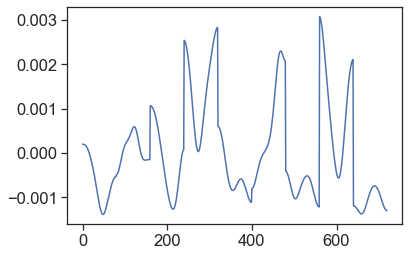

In [372]:
plt.plot((U.T.dot(store_g1_filt))[0])

In [352]:
np.cov(U[:,0],store_g1_filt[:,0])[0,1]

6.028259694076081e-06

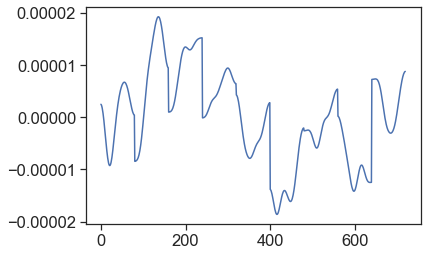

In [205]:
plt.plot(ccs)

In [206]:
ccs[0]/U.dot(store_g1_filt)[0][0]

2.232125236744107

In [207]:
np.var(store_g1_filt[0])

3.1522553729353235e-09

In [208]:
store_g1_filt[0].shape

(720,)

In [359]:
ccs = []
for ix_ in range(store_g1_filt.shape[1]):
    ccs.append(np.cov(U[:,0],store_g1_filt[:,ix_])[0,1])

In [23]:
import scipy.stats as stt

In [24]:
mu = np.mean(np.cumsum(np.abs(evals_shuff),axis=1),axis=1)
for i in np.abs(evals_shuff):
    plt.plot(np.cumsum(i),color='.3',linewidth=.5)
sem =np.std(np.cumsum(np.abs(evals_shuff),axis=1),axis=0)
plt.plot(np.cumsum(np.abs(true_evals)),linewidth=3)
plt.plot(mu,linewidth=3,color='.3',label='shuffle')
plt.fill_between(range(len(mu)),mu+2*sem,mu-2*sem,color='.3',alpha=.3)
plt.legend()
seaborn.despine()

NameError: name 'evals_shuff' is not defined

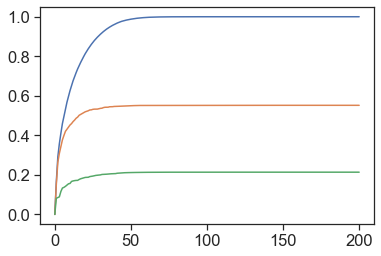

In [178]:
#this is the correct equation to testimate. This returns the corresponding D
evals = np.abs(U.T.dot(store_g1_filt).dot(V.T).diagonal())
mx = np.sum(evals)
plt.plot([0]+(np.cumsum(evals)/mx).tolist())

evals = np.abs(U.T.dot(store_g1_cv_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())


evals = np.abs(U.T.dot(store_g2_filt).dot(V.T).diagonal())
plt.plot([0]+(np.cumsum(evals)/mx).tolist())
#plt.ylim(.2,1)


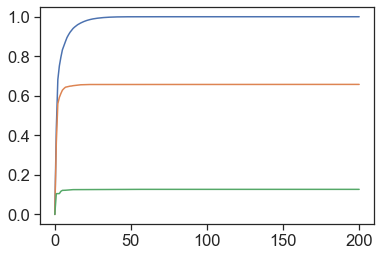

In [66]:
#this is the correct equation to testimate. This returns the corresponding D
evals = U.T.dot(store_g1_filt).dot(V.T).diagonal()**2
mx = np.sum(evals)
plt.plot([0]+(np.cumsum(evals)/mx).tolist())

evals = U.T.dot(store_g1_cv_filt).dot(V.T).diagonal()**2
plt.plot([0]+(np.cumsum(evals)/mx).tolist())


evals = U.T.dot(store_g2_filt).dot(V.T).diagonal()**2
plt.plot([0]+(np.cumsum(evals)/mx).tolist())